#### Word2vec

What is Word2Vec? A brief explanation:

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering. [Source](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial)

In summary, Word2Vec is a method to construc a word embedding. It can be obtained using two methods (both involving Neural Networks): Skip Gram and Common BOW (CBOW). According to literature, Skip Gram works well with small amount of data and is found to represent rare words well. On the other hand, CBOW is faster and has better representations for more frequent words. [Source](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)

Im not going to explain how Word2Vec works but is important to understand that, in other embedding's methods like BoW, TF, TF-IDF and others,  each document is represented for a $n$-dimensional vector ($n$ is the number of unique tokens) and each element of this vector represents the "occurrence" of a specific token inside the document, now we will work with a $m$-dimensional vector where $m$ is the dimension of the hidden layer of NN and this vector will represent *each word*, thus a document will be represent for a $m x n$ matrix!: $n$ is the number of unique tokens in a document and $m$ is the dimension of the hidden layer )

What will we try to do with this method?

We will apply this embedding type to our logs and try to measure the similarity between the logs! Let's see what happens...

([Simpson data example using Word2vec](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial))

In [1]:
from functions import *
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

Import the data and the colorisation function:

In [2]:
ds= TplPionier(config=config.ds_small)
colorise=dataset.TplPionierColor()

ds.index

,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,estimated (s),real (s),diff (s),SECONDS
0,2021-01-01 05:11:56.662000+00:00,2021-01-01 05:13:55.424000+00:00,False,PIONIER,bob_ins,PIONIER_acq,True,False,400,159,121,118.0
1,2021-01-01 05:14:56.885000+00:00,2021-01-01 05:21:12.220000+00:00,False,PIONIER,bob_ins,PIONIER_gen_tec_scan,False,False,5,2,3,375.0
2,2021-01-01 05:21:10.097000+00:00,2021-01-01 05:21:12.220000+00:00,False,PIONIER,bob_23173,PIONIER_gen_tec_scan,False,False,5,2,3,2.0
3,2021-01-01 05:22:02.490000+00:00,2021-01-01 05:26:15.611000+00:00,False,PIONIER,bob_ins,PIONIER_obs_calibrator,False,False,308,413,65,253.0
4,2021-01-01 05:26:15.630000+00:00,2021-01-01 05:26:15.880000+00:00,False,PIONIER,bob_ins,PIONIER_gen_cal_kappa,False,False,125,0,85,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80,2021-01-01 19:11:33.498000+00:00,2021-01-01 19:11:58.376000+00:00,False,PIONIER,bob_ins,PIONIER_gen_tec_setup,False,False,30,25,5,24.0
81,2021-01-01 19:11:58.394000+00:00,2021-01-01 19:12:33.041000+00:00,False,PIONIER,bob_ins,PIONIER_gen_tec_standby,False,False,100,35,25,34.0
82,2021-01-01 23:42:24.783000+00:00,2021-01-01 23:42:29.354000+00:00,False,PIONIER,bob_ins,PIONIER_gen_tec_setup,False,False,30,5,25,4.0
83,2021-01-01 23:42:29.369000+00:00,2021-01-01 23:44:39.640000+00:00,False,PIONIER,bob_ins,PIONIER_gen_tec_fluxopt,False,False,-1,-1,-1,130.0


Now we will extract all the events from each trace and we will save them in a nested list replacing all the spaces with an underscore because, for our case, each event is a token:

In [3]:
serie= generate_serie(ds,colorise)
serie_pd=pd.DataFrame(serie, columns=['tokens'])
serie_pd.tokens.iloc[0][:5]

['Started_at_{}_(underlined)',
 'PIONIER_acq_--_Acquisition_(yellow)',
 "AOS_AO_MODE_=_'FULL_AO'",
 "TEL_COU_PMA_=_'{}'",
 "ISS_IAS_HMAG_=_'{}'"]

In [4]:
#nested list
corpus=[  row for row in serie_pd.tokens] 
print('First 5 tokens from the second trace: \n', corpus[3][:5])

First 5 tokens from the second trace: 
 ['Started_at_{}_(underlined)', 'PIONIER_obs_calibrator_--_Observation_of_calibrator_(yellow)', "DPR_CATG_=_'CALIB'", "DPR_TECH_=_'INTERFEROMETRY'", "SEQ_NEXPO_=_'{}'"]


Let's import the Word2Vec method from the gensim library , we will not explore the parameters ([More info](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)). 

Default parameters:

- vector_size= (int, optional) – Dimensionality of the word vectors
- window= (int, optional) – Maximum distance between the current and predicted word within a sentence
- min_count= (int, optional) – Ignores all words with total frequency lower than this
- sg= ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW
- alpha= (float, optional) – The initial learning rate
- epoch= (int, optional) – Number of iterations (epochs) over the corpus. (Formerly: iter)

Note: we are using skip-gram training algorithm because we are working with a small amount of data.

In [5]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(corpus, vector_size=100, window=3, min_count=1,sg=1, alpha=0.001, epochs=10)
model.save('Word2VecLogs')

c:\Users\ruben\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [6]:
import gensim
model = gensim.models.Word2Vec.load(r'Word2VecLogs')
wv = model.wv
words = list(model.wv.key_to_index)
print("Number of tokens: ",len(words))

Number of tokens:  595



--------------------------------------------------------------------------------------------------------------
Reminder of the colorisation function:

In [7]:
trace= ds.load_trace(6, cols=['@timestamp','event'])
trace['colour']= trace['event'].apply(colorise.color)
trace['no spaces']=trace['colour'].apply(deleting_spaces)
pd.set_option('max_colwidth', 400)
trace[ ['event', 'colour','no spaces']].head(10)

,event,colour,no spaces
0,PIONIER_acq -- Acquisition (yellow),PIONIER_acq -- Acquisition (yellow),PIONIER_acq_--_Acquisition_(yellow)
1,Started at 2021-01-01T05:27:28 (underlined),Started at {} (underlined),Started_at_{}_(underlined)
2,SEQ OPL BEAM3 = '0.0',SEQ OPL BEAM3 = '{}',SEQ_OPL_BEAM3_=_'{}'
3,INS MODE = 'OBSERV-H',INS MODE = 'OBSERV-H',INS_MODE_=_'OBSERV-H'
4,AOS AO MODE = 'FULL_AO',AOS AO MODE = 'FULL_AO',AOS_AO_MODE_=_'FULL_AO'
5,INS DISP NAME = 'GRISM',INS DISP NAME = 'GRISM',INS_DISP_NAME_=_'GRISM'
6,SEQ OPL BEAM1 = '0.0',SEQ OPL BEAM1 = '{}',SEQ_OPL_BEAM1_=_'{}'
7,SEQ OPL BEAM2 = '0.0',SEQ OPL BEAM2 = '{}',SEQ_OPL_BEAM2_=_'{}'
8,SEQ DL PRESET = 'T',SEQ DL PRESET = 'T',SEQ_DL_PRESET_=_'T'
9,ISS VLTITYPE = 'imaging',ISS VLTITYPE = 'imaging',ISS_VLTITYPE_=_'imaging'


----------------------------------------------------

Now that we have our model trained, it is time to make the queries. For example, if we want no know what are the 5 closest events to:

  `PIONIER_acq -- Acquisition (yellow)`

from the trace 6 (preload before)

In [8]:
model.wv.most_similar( trace['no spaces'].iloc[0] )[:5]

[("Last_Reply_to_'SETUP'_from_'DCS'_received:_'{},,DET1.FRAM.NAMING_request_DET1.FRAM.FILENAME_PIONIER_GEN_{}'_(len='{}')",
  0.294434517621994),
 ('Waiting_(timeout_{})_for_pending_replies_to_command_OFFSOPD_id_{cmdXXX}',
  0.28466686606407166),
 ('OBS.EXEC.LOAD_OB_loaded', 0.2365604192018509),
 ('SETUP_-expoId_{}_-function_INS.MODE_CALIB-H_DET.DIT_{}_DET.NDIT_{}_DET.POLAR',
  0.22591634094715118),
 ('STATUS_-function_DET.DL3.ZEROOPD_(blue)', 0.22568652033805847)]

We can provided to this model a full preprocessed trace:

In [9]:
model.wv.most_similar( corpus[0] )[:5]

[('{}_(SpringGreen4)', 0.3625538945198059),
 ('INS.LAMP1.STOP_Lamp_turned_off.', 0.3397630751132965),
 ('{}_-_ic0fbControlSrv.C:{}:_Changing_substate_from:_BUSY_to:_IDLE',
  0.329639732837677),
 ('SETUP_-expoId_{}_-function_INS.SHUT1.ST_T_INS.SHUT2.ST_T_INS.SHUT3.ST_T_INS.SHUT4.ST_T_INS.MODE_OBSERV-H_DET.NDIT_{}_(blue)',
  0.31917160749435425),
 ("Send_command_'STATUS'_',DET.TRK.ST,FALSE'_to_sub-system_'DCS'_...",
  0.3127216696739197)]

We can see how similar are two events to each other:

In [10]:
print(trace['no spaces'].iloc[0], '\n', trace['no spaces'].iloc[12])
model.wv.similarity( trace['no spaces'].iloc[0], trace['no spaces'].iloc[12])

PIONIER_acq_--_Acquisition_(yellow) 
 TEL_COU_DELTA_=_'{}'


0.1547568

We can ask our model the event that does not belong to the list (this is more useful if we use specific traces)

In [11]:
model.wv.doesnt_match( corpus[0])

'TPL.CHANGE_template_parameters_have_been_edited'

or for analogy difference, for example, which word is to woman as man is to king?

In [12]:
model.wv.most_similar( positive= [trace['no spaces'].iloc[0],trace['no spaces'].iloc[1]], negative=[trace['no spaces'].iloc[0]], topn=3)

[("Last_Reply_to_'STATUS'_from_'DCS'_received:_'DET.SUBWIN.YREF_{}'_(len='{}')",
  0.310158371925354),
 ('{}_-_ic0fbDevSrv_standbyCb.C:{}:_Brought_device:_SHUT2_to_STANDBY_state',
  0.2865839898586273),
 ('..._calibration{ARG}PIONIER_cal.seq{ARG}{}{ARG}$Revision:_{}_$"_TPL.NEXP_{}_TPL.EXPNO_{}_(blue)',
  0.2848435342311859)]

What could this be useful for? 

Since we don't know the events used in comparison to an expert, we can not give an opinion on wheter this model is useful or not, but it serves to show that more potentially useful tools are out there. Having said that, the following ideas are proposed:

- construct a matrix distances using the word2vec representation for each traces and evaluate, for example:
    - what are the most distant traces, or the closest traces (or evaluate for a specific trace)
    - what are the closest trace for a error-trace.
    - what are the closest error traces, etc.
    
    note: for construct the word2vec representation for a trace we have to join all the vectors for each of its tokens and obtain its centroid, so the final representation for a trace will be a vector (the same length of vector-token)

- construct a matrix distances using only error-traces and identify which are the most distant trace-errors from the rest and try to characterize them.
- Apply a dimension reduction over this embedding values and use these new values for classification or visual representation.

And much more!

Let's go deeper into this last point, using PCA ([Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) to reduce the number of variables of our embedding values while preserving as much information as possible (there is a linear transformation behind) we can  visualize our data in 3 dimension more reliably!

Note: the idea of the following code is to obtain a visual representation of specific events (rare events, events from more distant traces, etc), but since we haven't obtained that conclusions yet we will use the last 20 events of a error-trace.

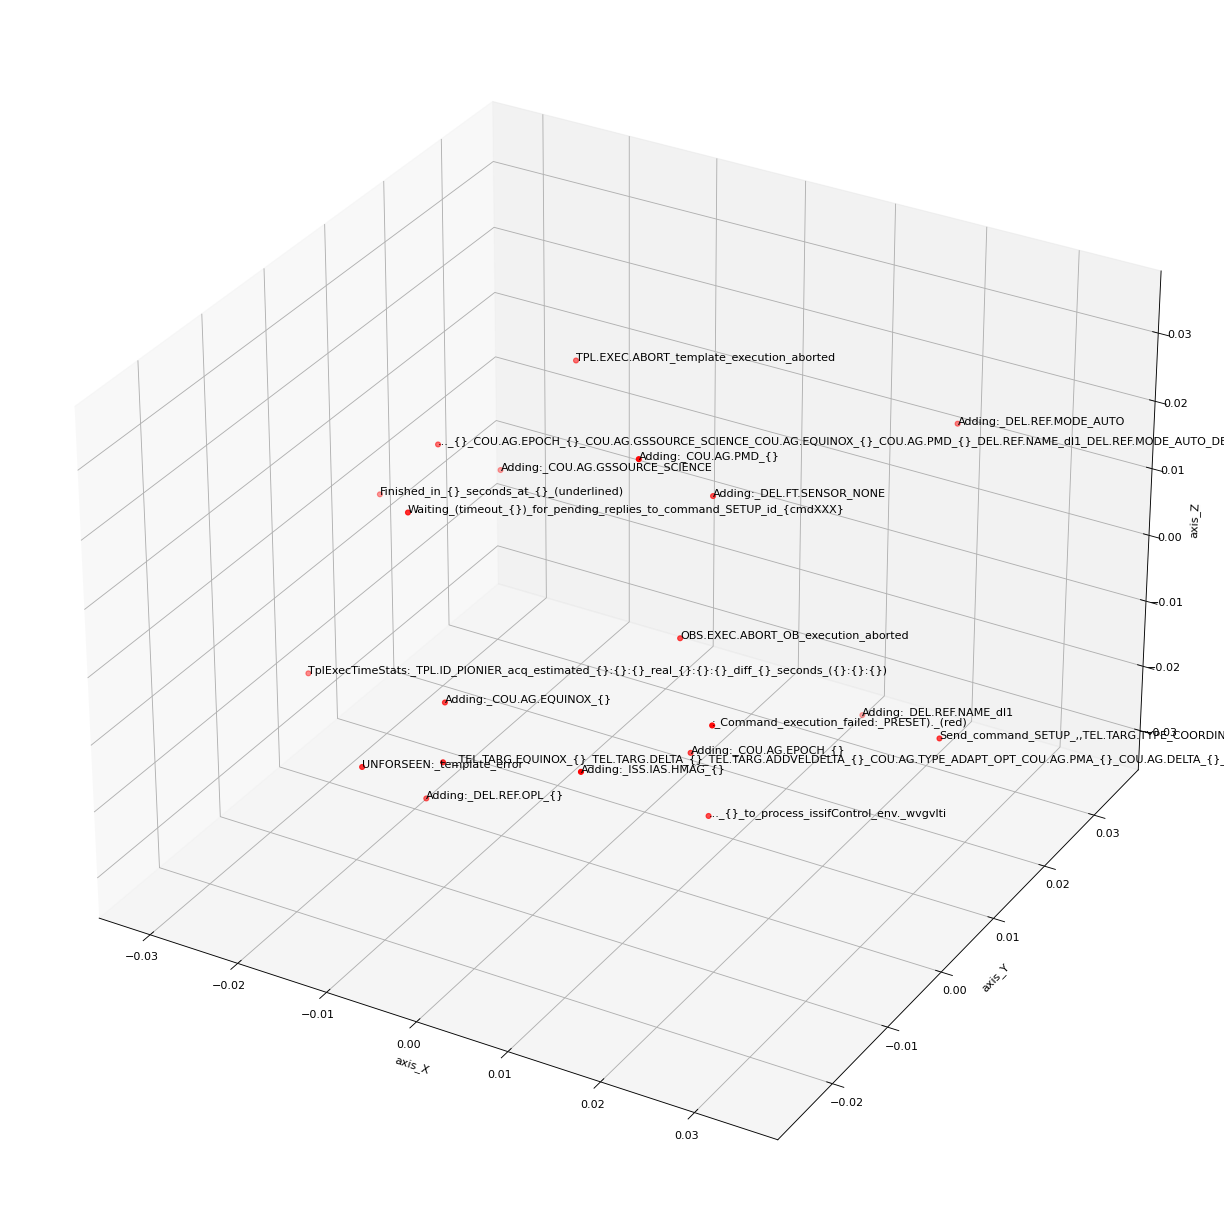

In [13]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

#trace 23
words = corpus[23][-20:]
vectors = []
for w in words:
    vectors.append(wv[w])
pca=PCA(n_components=3)
df3d=pd.DataFrame(pca.fit_transform(vectors),columns=list('xyz'))
x=df3d['x']; y=df3d['y']; 
z=df3d['z']
fig = plt.figure(figsize = (40, 20), dpi=80)
ax = plt.axes(projection ="3d")
ax.scatter3D(x, y, z, color = "red", marker='o')
ax.set_xlabel('axis_X')
ax.set_ylabel('axis_Y')
ax.set_zlabel('axis_Z')
for i, w in enumerate(words):
    ax.text(x[i],y[i],z[i],w)
plt.show()